# RNN for Time Series

In [1]:
# 2, 4, 6, 8
# 10, 12, 14, 16
# 10.1, 12.3, 14.6, the error will increase

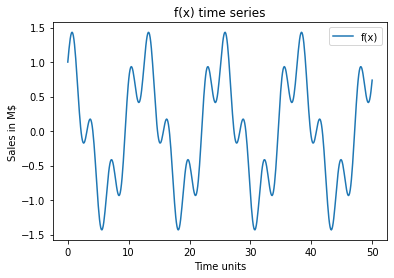

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def f(t): return .5*np.sin(2*t)+np.cos(.5*t)
x = np.linspace(0, 50, 500)
df = pd.DataFrame(f(x), index=x, columns=["f(x)"])
df.plot(title = "f(x) time series", xlabel="Time units", ylabel="Sales in M$");

## Train|test split

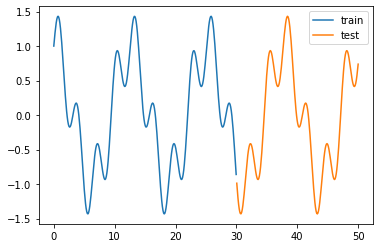

In [3]:
test_split = 200
df_train = df.iloc[:-test_split]
df_test = df.iloc[-test_split:]

ax = plt.axes()
df_train.plot(ax=ax)
df_test.plot(ax=ax)
plt.legend(["train", "test"])

### Scale Data

In [4]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaled_train = scaler.fit_transform(df_train)
scaled_test = scaler.transform(df_test)

scaled_train.shape, scaled_test.shape, scaled_test.min(), scaled_test.max()

((300, 1), (200, 1), -7.007746663628689e-05, 0.9998209929499919)

### Time Series Batches

format: (batch_size, time_steps, dimensionality)

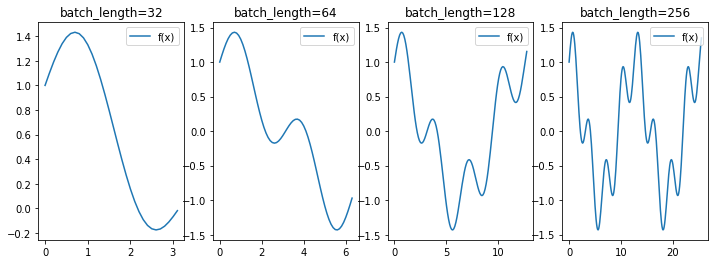

In [5]:
batch_lengths = [32, 64, 128, 256]

_, axes = plt.subplots(1, 4, figsize=(12, 4))

for batch_length, ax in zip(batch_lengths, axes): # We want to check if we can see the trend in each batch
    df_train.iloc[:batch_length].plot(ax=ax)
    ax.set_title(f"{batch_length=}")

# We may have to subsample the data and get less details and make it easier for the network to learn
# The batch length has to be shorter than the test data set

In [6]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

batch_length, batch_size = 128, 1 #batch size is the number of steps in the future that we want to predict 

train_generator = TimeseriesGenerator(scaled_train, scaled_train, length=batch_length, batch_size=batch_size) #We use scaled_train two times (this is common, but Kokchun does not know the reason why)
test_generator = TimeseriesGenerator(scaled_test, scaled_test, length=batch_length, batch_size=batch_size)

X, y = train_generator[0]
X.shape, y.shape 
#X.shape (1=batch_size, 128=time_steps, 1=dimension)

((1, 128, 1), (1, 1))

In [7]:
X[0, -3:, 0], scaled_train[batch_length-3:batch_length].flatten() #We check that we get the same values

(array([0.83464241, 0.86948818, 0.90263712]),
 array([0.83464241, 0.86948818, 0.90263712]))

In [8]:
y, scaled_train[batch_length]

(array([[0.93272665]]), array([0.93272665]))

### RNN Model

In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense

def RNN_model(RNN_layers):
    model = Sequential()
    model.add(RNN_layers)
    model.add(Dense(1)) #No activation, gives linear layer, we get regression
    model.compile(loss="mse", optimizer="adam")
    return model


RNN_layers = SimpleRNN(batch_length, return_sequences=False, input_shape=(None, 1)) #Batch length as the number of nodes
#With a deep RNN we should have return_sequences=True, when False there is no unrolling in the time dimension

model = RNN_model(RNN_layers)
model.summary()

Model: "sequential"
_________________________________________________________________


2022-05-09 11:16:19.938127: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 128)               16640     
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 16,769
Trainable params: 16,769
Non-trainable params: 0
_________________________________________________________________


In [10]:
model.fit(train_generator, epochs=10, validation_data=test_generator)

Epoch 1/10
172/172 [==============================] - 8s 37ms/step - loss: 0.0210 - val_loss: 2.2133e-04
Epoch 2/10
172/172 [==============================] - 6s 36ms/step - loss: 8.0458e-04 - val_loss: 1.5794e-04
Epoch 3/10
172/172 [==============================] - 6s 34ms/step - loss: 1.2204e-04 - val_loss: 8.4868e-05
Epoch 4/10
172/172 [==============================] - 6s 34ms/step - loss: 2.8296e-04 - val_loss: 6.1091e-04
Epoch 5/10
172/172 [==============================] - 6s 35ms/step - loss: 9.4644e-05 - val_loss: 2.8558e-05
Epoch 6/10
172/172 [==============================] - 8s 48ms/step - loss: 7.1260e-04 - val_loss: 3.3482e-05
Epoch 7/10
172/172 [==============================] - 8s 45ms/step - loss: 2.1480e-04 - val_loss: 1.3907e-05
Epoch 8/10
172/172 [==============================] - 8s 49ms/step - loss: 4.5349e-05 - val_loss: 1.8797e-05
Epoch 9/10
172/172 [==============================] - 9s 54ms/step - loss: 6.4034e-05 - val_loss: 2.1965e-05
Epoch 10/10
172/172 [==

<AxesSubplot:>

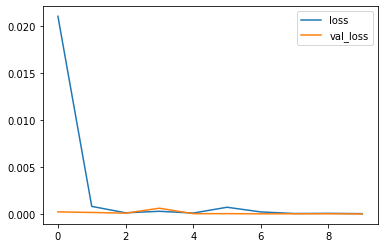

In [11]:
df_loss = pd.DataFrame(model.history.history)
df_loss.plot()

### Predictions

We want to predict values further in the future

In [12]:
predictions = np.zeros([len(scaled_test), 1])
first_batch = scaled_train[-batch_length:]
print(f"{first_batch.shape=}")
new_batch = first_batch[None, :]
print(f"{new_batch.shape=}") 

for i, _ in enumerate(df_test.values):
    new_pred = model.predict(new_batch)
    predictions[i] = new_pred[0] #It gets an extra dimension and we pick out the the inner
    new_batch = np.append(new_batch[:, batch_size:, :], [new_pred], axis=1) #It will start at 1
y_pred = scaler.inverse_transform(predictions) #We can invert the scaling
y_pred[:3], df_test.iloc[:3].values

first_batch.shape=(128, 1)
new_batch.shape=(1, 128, 1)


(array([[-0.99252939],
        [-1.10750205],
        [-1.21195059]]),
 array([[-0.98731583],
        [-1.10404617],
        [-1.20694873]]))

<AxesSubplot:>

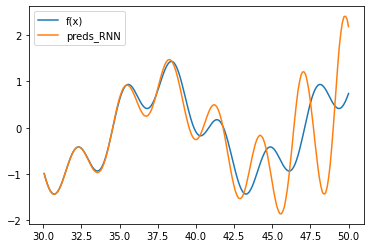

In [15]:
df_test.insert(df_test.shape[1], "preds_RNN", y_pred)
df_test.plot()

<AxesSubplot:>

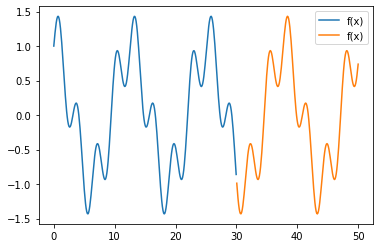

In [14]:
ax = df_train.plot()
df_test.plot(ax=ax)

## Forecasting

- predicting into the unknown future
- train on all data

In [16]:
from tensorflow.keras.layers import LSTM

LSTM_layer = LSTM(batch_length, return_sequences=False, input_shape=(None, 1))
model = RNN_model(LSTM_layer)

In [17]:
scaler = MinMaxScaler()
all_data = scaler.fit_transform(df)
all_data_generator = TimeseriesGenerator(
    all_data, all_data, length=batch_length, batch_size=batch_size
)

model.fit(all_data_generator, epochs=7)

Epoch 1/7
372/372 [==============================] - 37s 93ms/step - loss: 0.0163
Epoch 2/7
372/372 [==============================] - 48s 129ms/step - loss: 0.0016
Epoch 3/7
372/372 [==============================] - 36s 98ms/step - loss: 4.1723e-04
Epoch 4/7
372/372 [==============================] - 33s 90ms/step - loss: 1.3867e-04
Epoch 5/7
372/372 [==============================] - 35s 95ms/step - loss: 6.2344e-05
Epoch 6/7
372/372 [==============================] - 38s 102ms/step - loss: 3.0158e-05
Epoch 7/7
372/372 [==============================] - 40s 106ms/step - loss: 2.8357e-05


In [20]:
steps_in_future = 200

predictions = np.zeros([steps_in_future, 1])
first_batch = all_data[-batch_length:]
new_batch = first_batch[None, :]

for i in range(steps_in_future):
    new_pred = model.predict(new_batch)
    predictions[i] = new_pred[0] #[0] It gets an extra dimension and we pick out the the inner
    new_batch = np.append(new_batch[:, batch_size:, :], [new_pred], axis=1) #It will start at 1
y_pred = scaler.inverse_transform(predictions) #We can invert the scaling

In [21]:
x_future = np.linspace(50.1, 50.1 + steps_in_future*.1, num=steps_in_future) #future time steps

df_forecast = pd.DataFrame(y_pred, columns=["Forecast"], index=x_future)
df_forecast.head()

,Forecast
50.100000,0.839910
50.200503,0.942724
50.301005,1.046715
50.401508,1.148197
50.502010,1.243413


<AxesSubplot:>

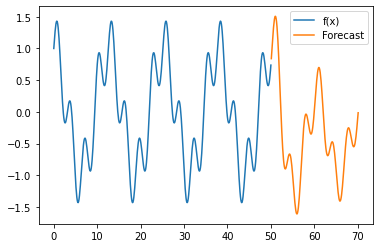

In [22]:
ax = df.plot()
df_forecast.plot(ax=ax)

<AxesSubplot:>

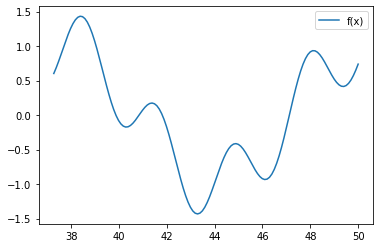

In [23]:
df.iloc[-batch_length:].plot() #This is the structure that the model had seen, so it was difficult to learn (maybe need larger batch length)